# **I. Install and import packages**

In [ ]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow
!pip install "tensorflow-text>=2.10"
!pip install einops

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 19 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 14s (31.9 MB/s)
(Reading database ... 124016 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 t

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text
import tensorflow_text as tf_text

# **II. Data handling**

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/NLP_project_/Data/Spider_FR2SQL_data.csv')
df

,sql_original,fr_sentence
0,['SELECT count(*) FROM head WHERE age > 56'],Combien de chefs de service ont plus de 56 ans ?
1,"['SELECT name , born_state , age FROM head ORD...","Indiquez le nom, l'état de naissance et l'âge ..."
2,"['SELECT creation , name , budget_in_billions ...","Indiquez l'année de création, le nom et le bud..."
3,"['SELECT max(budget_in_billions) , min(budget_...",Quels sont le budget maximum et minimum des dé...
4,['SELECT avg(num_employees) FROM department WH...,Quel est le nombre moyen d'employés des départ...
...,...,...
9688,['SELECT Citizenship FROM singer WHERE Birth_Y...,Quelles sont les nationalités partagées par le...
9689,['SELECT count(*) FROM Other_Available_Features'],Combien y a-t-il de fonctionnalités disponible...
9690,['SELECT T2.feature_type_name FROM Other_Avail...,Quel est le nom du type de fonctionnalité de l...
9691,['SELECT T2.property_type_description FROM Pro...,Afficher les descriptions de type de propriété...


In [ ]:
context_raw = df['fr_sentence']
target_raw = df['sql_original']

In [ ]:
# Set up the tokenizer
# Download, extract, and import the saved_model
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True)
tokenizers = tf.saved_model.load(model_name)

184801/184801 [==============================] - 0s 0us/step


In [ ]:
MAX_TOKENS=128
def prepare_batch(pt, en):
  #######################################################################################################
  # The following function takes batches of text as                                                     #
  # input, and converts them to a format suitable for training.                                         #
  # It tokenizes them into ragged batches.                                                              #
  # It trims each to be no longer than MAX_TOKENS.                                                      #
  # It splits the target (English) tokens into inputs and labels.                                       #
  # These are shifted by one step so that at each input location the label is the id of the next token. #
  # It converts the RaggedTensors to padded dense Tensors.                                              #
  # It returns an (inputs, labels) pair.                                                                #
  #######################################################################################################
  pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
  pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
  pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

  en = tokenizers.en.tokenize(en)
  en = en[:, :(MAX_TOKENS+1)]
  en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
  en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

  return (pt, en_inputs), en_labels

In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64
def make_batches():
  ###################################################
  # The function below converts a dataset of        #
  # text examples into data of batches for training.#
  ###################################################
  is_train = np.random.uniform(size=(len(target_raw),)) < 0.8
  context_raw = df['fr_sentence']
  target_raw =  df['sql_original']
  return (
       tf.data.Dataset
      .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_batches = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .map(prepare_batch, tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .map(prepare_batch, tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# **III. The embedding and positional encoding layer**

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

# **IV. Add and normalize**

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

# **V. The cross attention layer**

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x
sample_ca = CrossAttention(num_heads=2, key_dim=512)

In [ ]:
class GlobalSelfAttention(BaseAttention):
  ###################################
  # The global self attention layer #
  ###################################
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x
    
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

In [ ]:
class CausalSelfAttention(BaseAttention):
  ###################################
  # The causal self attention layer #
  ###################################
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

# **VI. The feed forward network**

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

sample_ffn = FeedForward(512, 2048)

# **VII. The encoder layer**

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

# **VIII. The encoder**

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.


# **IX. The decoder layer**

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
class Decoder(tf.keras.layers.Layer):
  #########################################################
  # Define the decoder by extending tf.keras.layers.Layer #
  #########################################################
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

# **X. The Transformer**

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits


# **XI. Hyperparameters**

In [ ]:
num_layers = 5
d_model = 128
dff = 512
num_heads = 10
dropout_rate = 0.2

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

# **XII. Training**

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

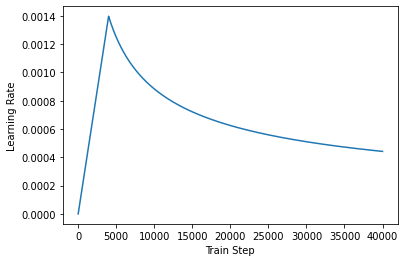

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

# **XIII. Set up the loss and metrics**

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)


# **XIV. Train the model**

In [ ]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy,masked_loss])

In [ ]:
history=transformer.fit(train_batches,
                epochs=70,
                validation_data=val_batches)

Epoch 1/70
123/123 [==============================] - 107s 527ms/step - loss: 8.5158 - masked_accuracy: 0.0599 - masked_loss: 8.5123 - val_loss: 8.0185 - val_masked_accuracy: 0.1060 - val_masked_loss: 8.0179
Epoch 2/70
123/123 [==============================] - 55s 449ms/step - loss: 7.2841 - masked_accuracy: 0.1617 - masked_loss: 7.2784 - val_loss: 6.3481 - val_masked_accuracy: 0.2386 - val_masked_loss: 6.3480
Epoch 3/70
123/123 [==============================] - 55s 449ms/step - loss: 5.5104 - masked_accuracy: 0.2682 - masked_loss: 5.5063 - val_loss: 4.6595 - val_masked_accuracy: 0.3404 - val_masked_loss: 4.6617
Epoch 4/70
123/123 [==============================] - 55s 451ms/step - loss: 4.0675 - masked_accuracy: 0.4162 - masked_loss: 4.0627 - val_loss: 3.3159 - val_masked_accuracy: 0.4868 - val_masked_loss: 3.3188
Epoch 5/70
123/123 [==============================] - 55s 448ms/step - loss: 2.8667 - masked_accuracy: 0.5335 - masked_loss: 2.8650 - val_loss: 2.3346 - val_masked_accurac

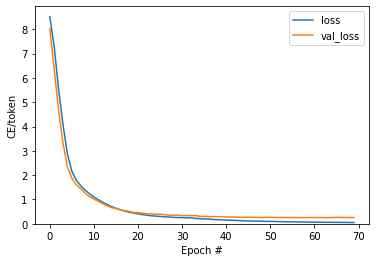

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

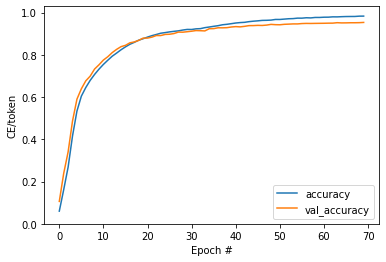

In [ ]:
plt.plot(history.history['masked_accuracy'], label='accuracy')
plt.plot(history.history['val_masked_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  4951680   
                                                                 
 decoder (Decoder)           multiple                  8152960   
                                                                 
 dense_24 (Dense)            multiple                  904290    
                                                                 
Total params: 14,008,930
Trainable params: 14,008,930
Non-trainable params: 0
_________________________________________________________________


# **XV. Define the Translator class by subclassing tf.Module**

In [ ]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights


In [ ]:
translator = Translator(tokenizers, transformer)

In [ ]:
def print_translation(sentence, tokens):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')

In [ ]:
sentence = "Combien d'étudiants qui ont 30 ans"
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text)

Input:         : Combien d'étudiants qui ont 30 ans
Prediction     : [ ' select count ( [UNK] ) from student where age = 30 ' ]


In [ ]:
sentence = "Renvoyer les hôtes de compétitions dont le thème n'est pas Aliens ?"
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text)

Input:         : Renvoyer les hôtes de compétitions dont le thème n'est pas Aliens ?
Prediction     : [ [UNK] select host _ city from farm where theme ! = ' aliens ' [UNK] ]


In [ ]:
sentence = "Combien d'étudiants qui ont 25 ans"
translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text)

Input:         : Combien d'étudiants qui ont 25 ans
Prediction     : [ ' select count ( [UNK] ) from student where age = 25 ' ]
